In [1]:
pip install pygame

In [2]:
from torch import nn
import torch
import gym
from collections import deque
import numpy as np
import random
import pygame
import matplotlib.pyplot as plt

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
#hyperparameters inspired from the openai base example 
gamma = 0.99
batch_size = 32
buffer_size = 500
min_replay_size = 100
epsilon_start = 1.0
epsilon_end = 0.02
epsilon_decay = 100 #revaluation of epsilon from start to the end in 100 steps
target_update_freq= 100
episodes = 1000

In [4]:
class Network(nn.Module):
    def __init__(self, env):
        super().__init__()
        in_features = int(np.prod(env.observation_space.shape))
        
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n))
        
        
    def forward (self, x):
        return self.net(x)
    
    def act (self, obs): #selects an action 
        obs_t = torch.as_tensor(obs, dtype = torch.float32) #torch tensor
        q_values = self(obs_t.unsqueeze(0)) #q values for this specific observation. unsqueeze = because we dont have the batch dimension
        max_q_index = torch.argmax(q_values, dim = 1)[0]
        action = max_q_index.detach().item() #action indecies, 
        return action 

In [5]:
#creating our environment - CartPole
env = gym.make('CartPole-v0')
replay_buffer = deque(maxlen = buffer_size) 
reward_buffer = deque([0.0], maxlen=100)#rewards earned by an agent in a signle episode
                        
episode_reward = 0.0

online_net = Network(env)
target_net = Network(env)

target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.Adam(online_net.parameters(), lr = 5e-4)

#replay buffer
obs = env.reset()
for _ in range(min_replay_size):
    action = env.action_space.sample()
    
    new_obs, rew, done, info = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs
    
    if done:
        obs = env.reset()
        
#main train loop
obs = env.reset()

for step in range(episodes):
    epsilon = np.interp(step, [0, epsilon_decay], [epsilon_start, epsilon_end]) #to facilitate exploration in the environment
    random_sample = random.random()
    if random_sample <= epsilon:
        action = env.action_space.sample()
    else:
        action = online_net.act(obs)
        
    new_obs, rew, done, info = env.step(action)
    transition = (obs, action, rew, done, new_obs)
    replay_buffer.append(transition)
    obs = new_obs
    episode_reward +=rew
    
    if done:
        obs = env.reset()
        reward_buffer.append(episode_reward)
        episode_reward = 0.0

        
    #starting gradient step
    transitions = random.sample(replay_buffer, batch_size) #samples batch size from our transitions from the replay buffer
    #creating a list from transitions for each element in seperate arays
    #pytorch much faster for making a torch tensor from numpy arrays than from python array  
    obses = np.asarray([t[0] for t in transitions]) 
    actions = np.asarray([t[1] for t in transitions])
    rews = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([t[4] for t in transitions])
    #transforming to tensors
    obses_t = torch.as_tensor(obses, dtype = torch.float32)
    actions_t =  torch.as_tensor(actions, dtype = torch.int64).unsqueeze(-1) #its index, so int 64
    rews_t =  torch.as_tensor(rews, dtype = torch.float32).unsqueeze(-1)#unsqueez adding dimensions
    dones_t =  torch.as_tensor(dones, dtype = torch.float32).unsqueeze(-1)
    new_obses_t =  torch.as_tensor(new_obses, dtype = torch.float32)
    
    
    #computer targets
    with torch.no_grad(): 
        target_online_q_values = online_net(new_obses_t) #a set of q values for each observations using online net
        targets_online_best_q_indices = target_online_q_values.argmax(dim=1, keepdim=True) #select  action indice with the  max q value in dimension 1
        targets_target_q_values = target_net(new_obses_t) #all the a values
        targets_selected_q_values = torch.gather(input=targets_target_q_values, dim=1, index = targets_online_best_q_indices) #selecting target based on the indece selected by the online network 
        
        targets = rews_t + gamma*(1-dones_t)*targets_selected_q_values
        
    #compute loss
    q_values = online_net(obses_t)#q values for each observation
    action_q_values = torch.gather(input = q_values, dim = 1, index=actions_t) # avalue for an actual action taken in the transition 
    
    loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    
    #gradient descent
    optimizer.zero_grad()
    loss.backward()#compute gradients
    optimizer.step()#apply gradients
    
    #update target network 
    if step % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
        
    if step % 10 == 0:
        print()
        print('Step', step)
        print('Avg reward', np.mean(reward_buffer))
        


Step 0
Avg reward 0.0

Step 10
Avg reward 0.0

Step 20
Avg reward 0.0

Step 30
Avg reward 12.5

Step 40
Avg reward 12.5

Step 50
Avg reward 12.5

Step 60
Avg reward 12.5

Step 70
Avg reward 22.0

Step 80
Avg reward 22.0

Step 90
Avg reward 21.25

Step 100
Avg reward 19.6

Step 110
Avg reward 18.5

Step 120
Avg reward 18.5

Step 130
Avg reward 17.857142857142858

Step 140
Avg reward 17.125

Step 150
Avg reward 17.125

Step 160
Avg reward 17.0

Step 170
Avg reward 16.6

Step 180
Avg reward 16.272727272727273

Step 190
Avg reward 15.916666666666666

Step 200
Avg reward 15.916666666666666

Step 210
Avg reward 15.692307692307692

Step 220
Avg reward 15.5

Step 230
Avg reward 15.066666666666666

Step 240
Avg reward 14.75

Step 250
Avg reward 14.470588235294118

Step 260
Avg reward 14.166666666666666

Step 270
Avg reward 14.0

Step 280
Avg reward 13.9

Step 290
Avg reward 13.666666666666666

Step 300
Avg reward 13.5

Step 310
Avg reward 13.347826086956522

Step 320
Avg reward 13.208333333333

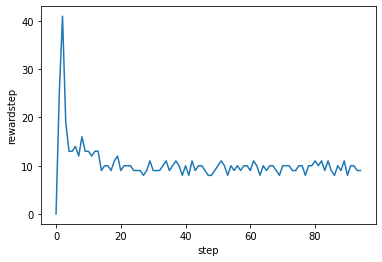

In [6]:
plt.plot(reward_buffer)
plt.ylabel('rewardstep')
plt.xlabel('step')
plt.show()